# State Inference in a Poisson LDS using the Conditional Moments Gaussian Smoother

Adapted from [https://github.com/lindermanlab/ssm-jax/blob/main/notebooks/poisson-lds-example.ipynb](https://github.com/lindermanlab/ssm-jax/blob/main/notebooks/poisson-lds-example.ipynb )


This notebook shows how to fit a linear dynamical system (LDS) with Poisson observations,
\begin{align*}
p(x_{1:T}, y_{1:T}; \theta) 
&= \mathrm{N}(x_1 \mid \mu_1, \Sigma_1) 
\prod_{t=2}^T \mathrm{N}(x_t \mid A x_{t-1} + b, Q) 
\prod_{t=1}^T \mathrm{Po}(y_t \mid f(C x_t + d))
\end{align*}

where $f$ is a rectifying nonlinearity (e.g., the _softplus_ function $f(a) = \log(1+e^a)$) applied element-wise to the vector $Cx_t + d$. 

This model is widely used for analyzing neural spike train data. Unfortunately, the Poisson likelihood is not conjugate with the Gaussian prior, so we need to perform approximate inference. The CMGF is well-suited to this task.

## Setup

In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from jax import vmap
from jax.nn import softplus
from tensorflow_probability.substrates.jax.distributions import Poisson

from dynamax.generalized_gaussian_ssm import ParamsGGSSM, GeneralizedGaussianSSM, EKFIntegrals
from dynamax.generalized_gaussian_ssm import conditional_moments_gaussian_smoother as cmgs
from dynamax.utils.utils import random_rotation

## Construct and Sample the Model

First, construct a model with 2-dimensional latent states that follow simple rotational dynamics, and Poisson emissions via a softplus link function. Then sample several independent "trials" (i.e., separate time series of $x$'s and $y$'s) from the model.

In [3]:
# Parameters for our Poisson demo
state_dim = 2
emission_dim = 10
num_timesteps = 200
num_trials = 3

# Sample random parameters
dynamics_matrix = random_rotation(jr.PRNGKey(0), state_dim, theta=jnp.pi/20)
emission_matrix = jr.normal(jr.PRNGKey(0), shape=(emission_dim, state_dim))
emission_bias = 3.0

# Create a generalized Gaussian SSM with Poisson emissions
params = ParamsGGSSM(
    initial_mean = jnp.zeros(state_dim),
    initial_covariance = jnp.eye(state_dim),
    dynamics_function = lambda z: dynamics_matrix @ z,
    dynamics_covariance = 0.001 * jnp.eye(state_dim),
    emission_mean_function = lambda z: softplus(emission_matrix @ z + emission_bias),
    emission_cov_function = lambda z: jnp.diag(softplus(emission_matrix @ z + emission_bias)),
    emission_dist = lambda mu, Sigma: Poisson(rate=softplus(mu))
)
model = GeneralizedGaussianSSM(state_dim, emission_dim)

# Sample several "trials" worth of data from the model
all_states, all_emissions = \
    vmap(lambda key: model.sample(params, key, num_timesteps=num_timesteps))(
        jr.split(jr.PRNGKey(0), num_trials))

Plot the first trial's states and emissions.

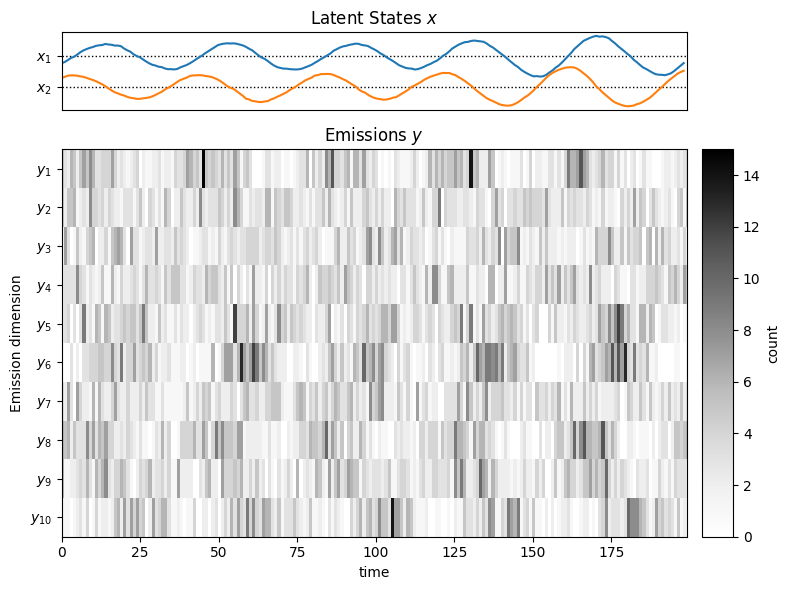

In [4]:
def plot_emissions_poisson(states, data):
    """
    Plot the emissions of a Poisson :DS
    """
    latent_dim = states.shape[-1]
    emissions_dim = data.shape[-1]
    num_timesteps = data.shape[0]

    fig, axs = plt.subplots(2, 2, 
                            height_ratios=(1, emissions_dim / latent_dim), 
                            width_ratios=(20,1), figsize=(8, 6))
    
    # Plot the continuous latent states
    lim = 1.5 * abs(states).max()
    for d in range(latent_dim):
        axs[0,0].axhline(-lim * d, color='k', ls=':', lw=1)
        axs[0,0].plot(states[:, d] - lim * d, "-")
    axs[0,0].set_yticks(-jnp.arange(latent_dim) * lim)
    axs[0,0].set_yticklabels(["$x_{}$".format(d + 1) for d in range(latent_dim)])
    axs[0,0].set_xticks([])
    axs[0,0].set_xlim(0, num_timesteps)
    axs[0,0].set_title(r"Latent States $x$")

    axs[0,1].set_visible(False)

    lim = abs(data).max()
    im = axs[1,0].imshow(data.T, aspect="auto", interpolation="none", cmap="Greys")
    axs[1,0].set_xlabel("time")
    axs[1,0].set_xlim(0, num_timesteps - 1)
    axs[1,0].set_yticks(jnp.arange(emissions_dim))
    axs[1,0].set_yticklabels([rf"$y_{{ {i+1}}}$" for i in jnp.arange(emissions_dim)])
    axs[1,0].set_ylabel("Emission dimension")
    axs[1,0].set_title(r"Emissions $y$")
    plt.colorbar(im, cax=axs[1,1], label="count")

    plt.tight_layout()
    
plot_emissions_poisson(all_states[0], all_emissions[0])

## Infer the Latent States

We can infer the latent states using the conditional moments Gaussian smoother (CMGS) with EKF-style integrals, as demonstrated below.

In [5]:
posts = vmap(lambda emissions: cmgs(params, EKFIntegrals(), emissions))(all_emissions)

Plot the CMGS posterior distribution over latent states given observations.

Text(0.5, 1.0, 'true and inferred states using CMGS')

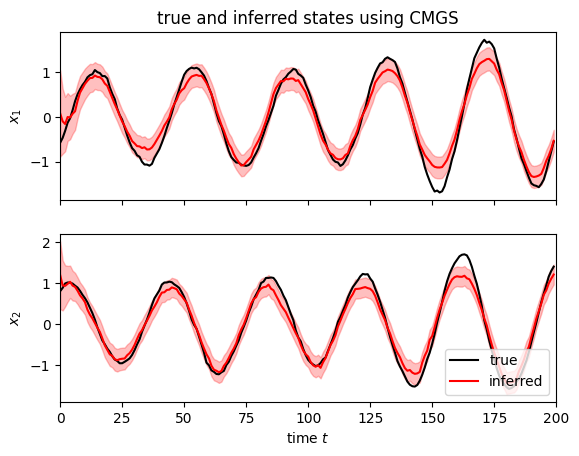

In [6]:
i = 0
fig, axs = plt.subplots(2, 1, sharex=True)
lim = 1.5 * abs(all_states[i]).max()
for d in range(2):
    axs[d].plot(all_states[i, :, d], "-k", label="true")
    axs[d].plot(posts.filtered_means[i, :, d], "-r", label="inferred")
    axs[d].fill_between(
        jnp.arange(num_timesteps),
        posts.filtered_means[i, :, d] - 2 * jnp.sqrt(posts.filtered_covariances[i, :, d, d]),
        posts.filtered_means[i, :, d] + 2 * jnp.sqrt(posts.filtered_covariances[i, :, d, d]),
        color="r",
        alpha=0.25,
    )
    axs[d].set_ylabel(rf"$x_{d+1}$")

axs[-1].set_xlabel(r"time $t$")    
axs[-1].legend(loc="lower right")
axs[-1].set_xlim(0, num_timesteps)
axs[0].set_title("true and inferred states using CMGS")

## Learning the Model Parameters

This notebook shows how to infer the latent states _given_ the model parameters. If you wanted to learn the model paramters, you could perform (stochastic) gradient ascent on the marginal log likelihood estimate returned by the CMGF, which are contained in the posterior:

In [7]:
posts.marginal_loglik

Array([-3862.326 , -3921.8684, -3808.4756], dtype=float32)

We won't go through the details of that here, but the process is analogous to what we showed in earlier notebooks for gradient based learning of parameters for HMMs and LGSSMs.

## Conclusion

Several models fall under the category of "General Gaussian SSMs." The conditional moments Gaussian filter and smoother allow us to infer the latent states of such models, as shown in this notebook.